<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [74]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

In [75]:
#df = df.apply(np.log)

In [76]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [77]:
timesteps = 25
df_train, df_test = df[0:-timesteps], df[-timesteps:]

# Check size
print(df_train.shape)  
print(df_test.shape) 

(3780, 9)
(25, 9)


In [78]:
from tqdm import tqdm

AIC = {}
best_aic, best_order = np.inf, 0

for i in tqdm(range(1,100)):
    model = VAR(endog=df_train.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER:', best_order, 'BEST AIC:', best_aic)

100%|██████████| 99/99 [00:29<00:00,  3.35it/s]

BEST ORDER: 4 BEST AIC: 24.01970061974111


In [79]:
model_fitted = model.fit(best_order)

In [80]:
# Get the lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]

In [81]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=timesteps)
df_forecast = pd.DataFrame(fc, index=df.index[-timesteps:], columns=df.columns)
df_forecast.head(1)

,% Silica Feed,Amina Flow,Flotation Column 01 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 02 Level,Flotation Column 03 Level,% Iron Concentrate,% Silica Concentrate
dates,,,,,,,,,
2017-09-09 02:30:00,20.675079,439.778211,299.352443,299.318179,299.910623,493.985913,410.779116,63.924887,3.160317


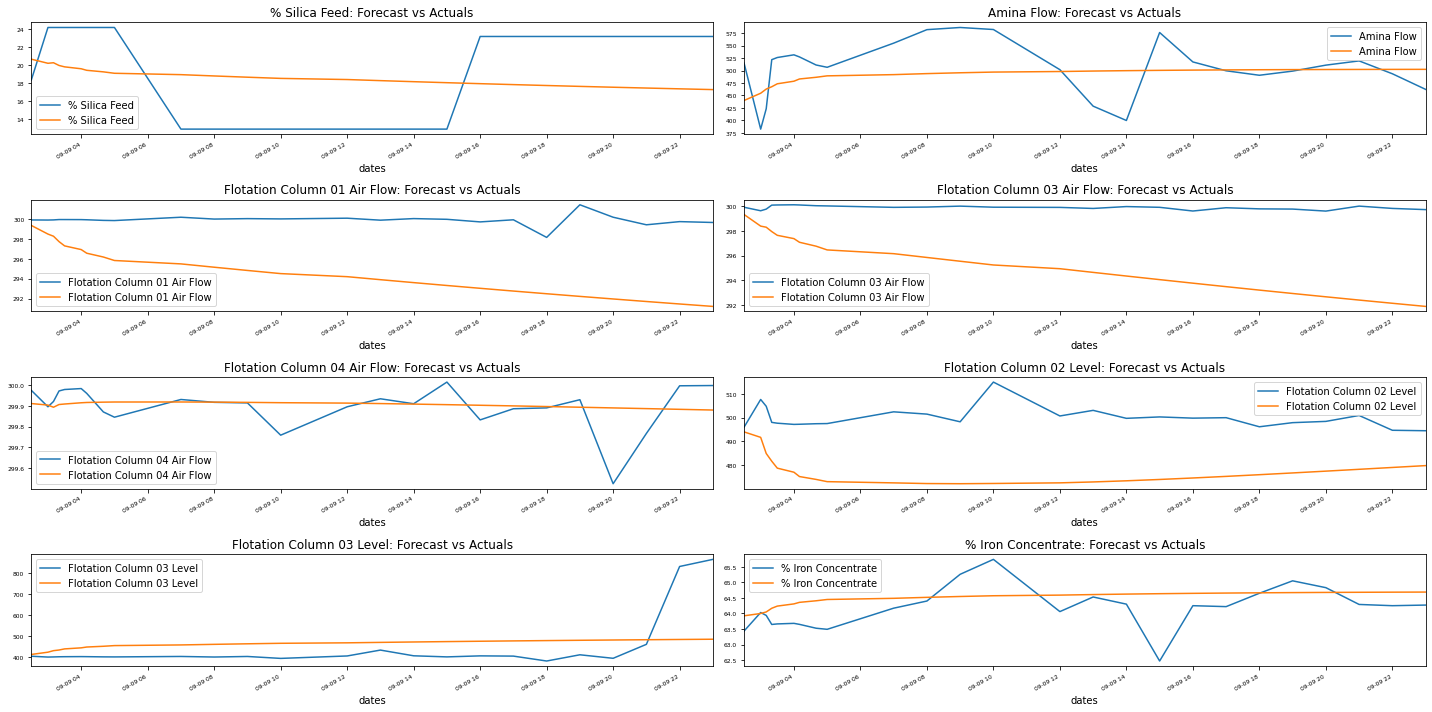

In [82]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, figsize=(20,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_test[col].plot(legend=True, ax=ax)
    df_forecast[col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)

    ax.set_title(col + ": Forecast vs Actuals")
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [83]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

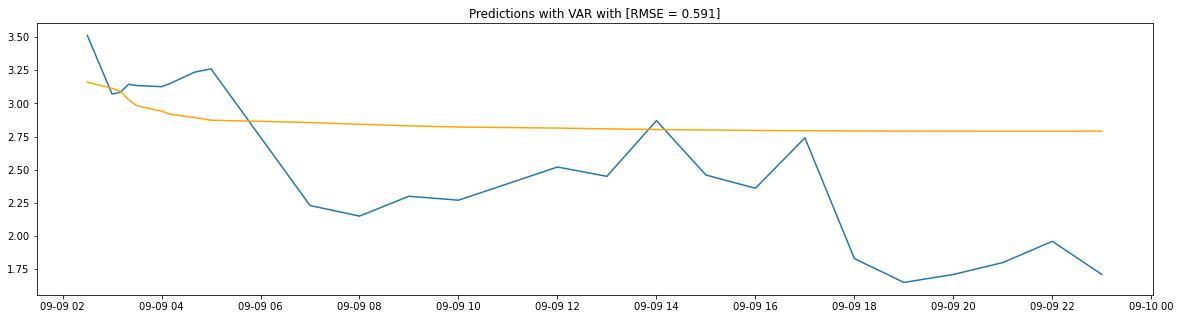

In [84]:
from sklearn.metrics import mean_squared_error
from math import sqrt

fig, ax = plt.subplots(figsize=(20,5))

mape, mae, rmse = forecast_accuracy(df_forecast['% Silica Concentrate'].values, df_test['% Silica Concentrate'])

# plot forecasts against actual outcomes
plt.plot(df_test['% Silica Concentrate'])
plt.plot(df_forecast['% Silica Concentrate'], color='orange')
plt.title("Predictions with VAR with [RMSE = %.3f]" % rmse)

plt.show()

In [85]:
for col in df.columns:
  print('Forecast Accuracy of: ', col)
  accuracy_prod = forecast_accuracy(df_forecast[col].values, df_test[col])
  print(accuracy_prod, '\n')

Forecast Accuracy of:  % Silica Feed
(0.2800618064285205, 5.104314393392735, 5.1704959921634375) 

Forecast Accuracy of:  Amina Flow
(0.08956575048694576, 44.74040464369556, 54.5670526607344) 

Forecast Accuracy of:  Flotation Column 01 Air Flow
(0.0172294588245454, 5.167607040965288, 5.680091516936) 

Forecast Accuracy of:  Flotation Column 03 Air Flow
(0.015285677439576475, 4.583537002590449, 5.034671095041975) 

Forecast Accuracy of:  Flotation Column 04 Air Flow
(0.0002168524288072368, 0.06501749447402971, 0.09879721961738964) 

Forecast Accuracy of:  Flotation Column 02 Level
(0.045306868080870026, 22.683266734467193, 23.802144845186) 

Forecast Accuracy of:  Flotation Column 03 Level
(0.1571774442463288, 78.32092161585712, 117.12437792463898) 

Forecast Accuracy of:  % Iron Concentrate
(0.008103593351185667, 0.5178567953639953, 0.6799520626737113) 

Forecast Accuracy of:  % Silica Concentrate
(0.2287117710614555, 0.47387980075935343, 0.5909597885657333) 

